# Assignment

We have considered many points in our last 5 lectures. Some of these we have covered directly and some indirectly. They are:

1. How many layers
2. MaxPooling
3. 1x1 Convolutions
4. 3x3 Convolutions
5. Receptive Field
6. SoftMax
7. Learning Rate
8. Kernels and how do we decide the number of kernels?
9. Batch Normalization
10. Image Normalization
11. Position of MaxPooling
12. Concept of Transition Layers
13. Position of Transition Layer
14. DropOut
15. When do we introduce DropOut, or when do we know we have some overfitting
16. The distance of MaxPooling from Prediction
17. The distance of Batch Normalization from Prediction
18. When do we stop convolutions and go ahead with a larger kernel or some other alternative (which we have not yet covered)
19. How do we know our network is not going well, comparatively, very early
20. Batch Size and Effects of Batch Size
21. *(You can add more if we've missed any)*

---

## Task

- Refer to this code: `COLABLINK`
- **Rewrite the model/code such that it achieves:**
  - **99.4% validation/test accuracy** (50/10k split; i.e., we are calling the validation dataset the test dataset itself)
  - **Less than 20k Parameters**
  - You can use anything from the listed points above.
  - **Less than 20 Epochs**
  - Must use **Batch Normalization** and **Dropout**.
  - *(Optional)*: Use a **Fully Connected Layer** or **GAP** (Global Average Pooling).

---

### Additional Learning Resource

To learn how to add different components like DropOut, BatchNorm, etc., **refer for technique only, do NOT copy the architecture**:  
[https://www.kaggle.com/enwei26/mnist-digits-pytorch-cnn-99](https://www.kaggle.com/enwei26/mnist-digits-pytorch-cnn-99) DONT COPY THE ARCHITECTURE, JUST LEARN HOW TO INTEGRATE THINGS LIKE DROPOUT, BATCHNORM, ETC.

---

## Instructions

- This is a slightly time-consuming assignment. **Start early!**
- You may need to run your program multiple times and spend considerable effort tuning.

---

## Submission Checklist

- **Upload your assignment to a public GitHub repository.**
- Use Cursor to write code and show in your README the following details (well formatted):
  - Total Parameter Count
  - Confirmation of use of Batch Normalization
  - Confirmation of use of Dropout
  - Confirmation of use of a Fully Connected Layer or GAP
- **Do NOT misrepresent your answers** – will result in a score of -100%
- **Do NOT submit only a Colab link or redirect your GitHub to Colab** – will result in a score of -50%
- **Submit details to “Session 5 - Assignment Q&A”**:
  - Your repository link, making sure we can see your test logs (to see test accuracy) in the README
  - Your Validation/Test Accuracy Number

---

**Scoring:**
- GitHub Repo with test logs in README: [200 points]
- Validation/Test Accuracy Number: [500 points]

# Read the MNIST dataset
This notebook demonstrates how to train a Convolutional Neural Network (CNN) to recognize handwritten digits from the MNIST dataset using PyTorch with < 20000 parameters, >= 99.4% validation accuracy and < 20 epochs

In [38]:
import torch
import torch.nn as nn
from torchvision import transforms
from datasets import load_dataset, concatenate_datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random
import numpy as np

## Reduce Image Size
When you observe the MNIST dataset, you will see there are a lot of black pixel padding before the actual image starts. Here I am trying to do a quick check to see what is the least amount of such padding across the all images. If we could reduce the image size we could reduce the layers required for the receptive field. Why not attempt?

In [39]:
# Load and concatenate datasets
dataset = load_dataset("mnist")
full_dataset = concatenate_datasets([dataset['train'], dataset['test']])

# Method 1: Direct conversion
images = full_dataset['image']  # This gets list of PIL Images
# Convert PIL images to tensor
image_tensor = torch.stack([transforms.ToTensor()(img) for img in images])
# Remove the channel dimension (MNIST is grayscale, so it's 1x28x28)
image_tensor = image_tensor.squeeze(1)  # Now 70000x28x28

print(image_tensor.shape)  # torch.Size([70000, 28, 28])

torch.Size([70000, 28, 28])


Original shape: torch.Size([70000, 28, 28])
Cropped shape: torch.Size([70000, 28, 28])
Crop boundaries (min_row, max_row, min_col, max_col): (0, 28, 0, 28)
Reduction: 784 -> 784 pixels per image
Images touching boundaries:
Min row (0): 2 images
Max row (27): 812 images
Min col (0): 16 images
Max col (27): 92 images


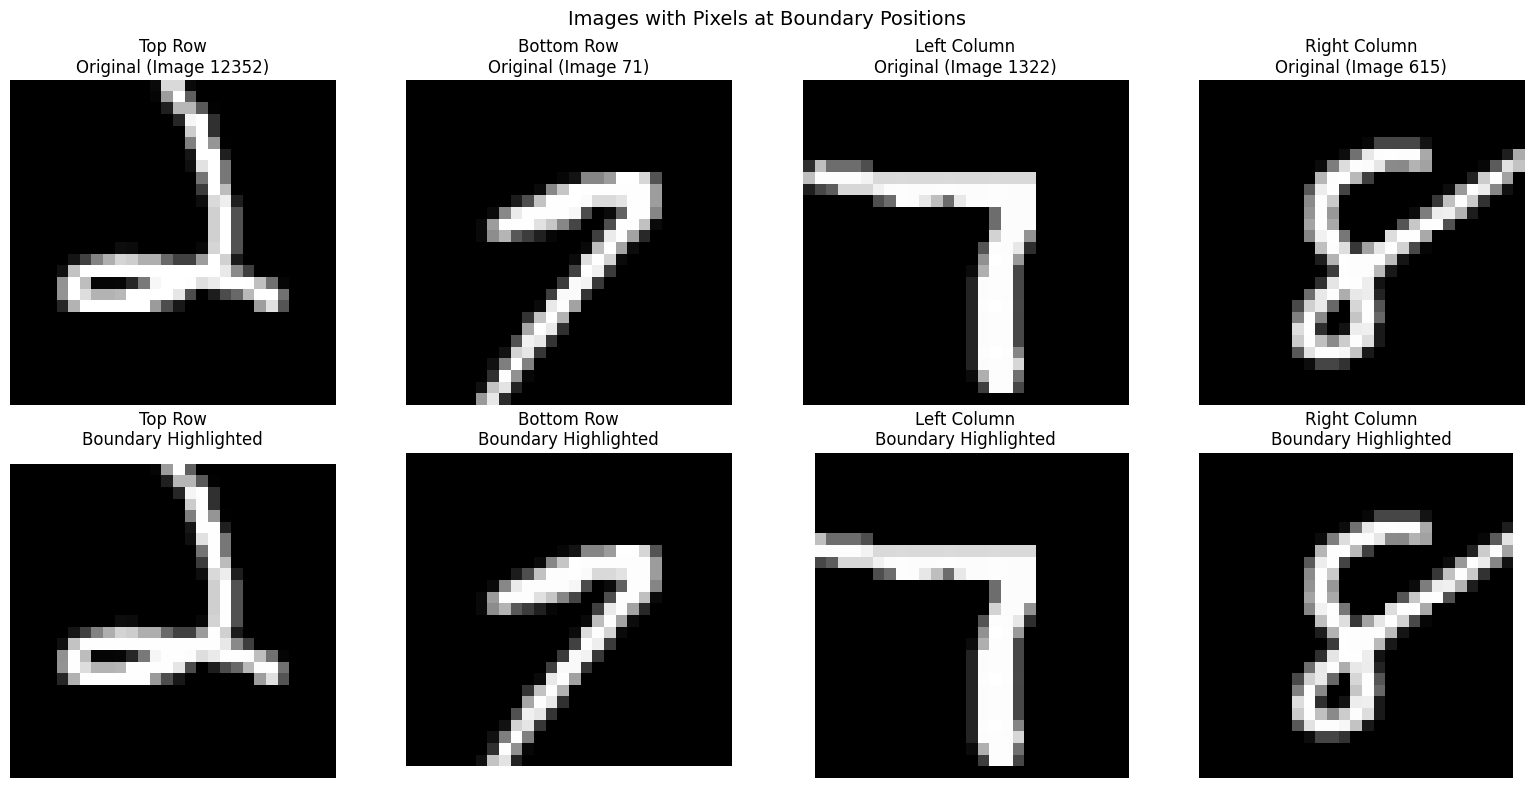


First few image indices for each boundary:
min_row: [12352, 12905]
max_row: [71, 91, 123, 196, 282]
min_col: [1322, 11603, 11898, 15513, 21699]
max_col: [615, 627, 1243, 1852, 2893]

SHOWING SPECIFIC BOUNDARY IMAGES


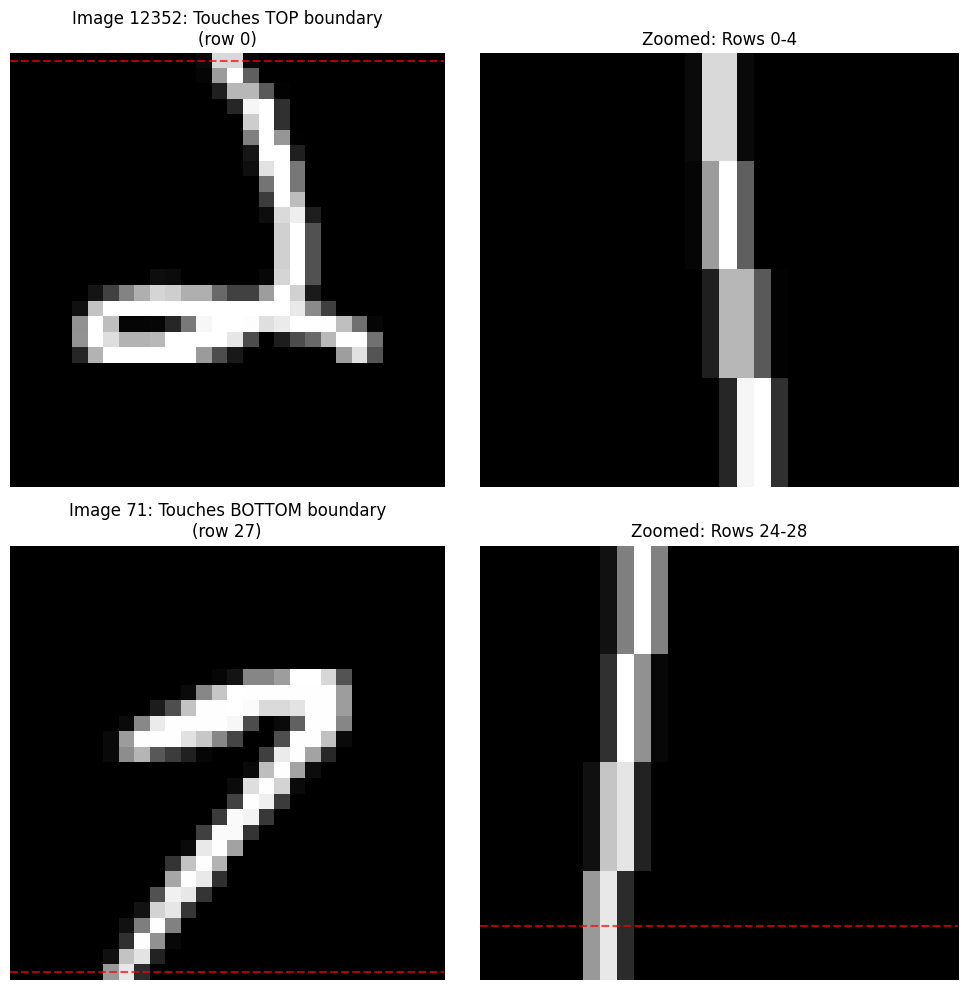


Detailed Analysis:
Image 12352 (touches top):
  - Label: 2
  - Max pixel value in top row (0): 0.847
  - Number of pixels > 0.01 in top row: 4
Image 71 (touches bottom):
  - Label: 7
  - Max pixel value in bottom row (27): 0.902
  - Number of pixels > 0.01 in bottom row: 3

Crop boundaries determined by these extreme images:
Final crop will be [0:28, 0:28]
This removes 0 rows/cols of pure black pixels


In [40]:
import torch
import torch.nn.functional as F
from datasets import load_dataset, concatenate_datasets
import numpy as np

def crop_mnist_images_cuda(image_tensor, threshold=0.01, device='cuda'):
    """
    Crop MNIST images to remove black pixels from all sides while preserving all white pixel information.

    Args:
        image_tensor: Tensor of shape (N, H, W) with values in [0, 1]
        threshold: Minimum pixel value to consider as "white" (default: 0.01)
        device: Device to run computation on

    Returns:
        Cropped tensor and crop boundaries
    """

    # Move to CUDA
    images = image_tensor.to(device)
    N, H, W = images.shape

    # Create binary mask for non-black pixels (above threshold)
    non_black_mask = images > threshold  # Shape: (N, H, W)

    # Find global bounding box across all images
    # For each image, find where non-black pixels exist

    # Method 1: Find min/max coordinates across all images
    # Get coordinates of all non-black pixels
    non_black_coords = torch.nonzero(non_black_mask, as_tuple=False)  # Shape: (num_pixels, 3) -> [img_idx, row, col]

    if non_black_coords.size(0) == 0:
        # All images are completely black
        return images, (0, H, 0, W)

    # Extract row and column coordinates
    rows = non_black_coords[:, 1]  # All row coordinates
    cols = non_black_coords[:, 2]  # All column coordinates

    # Find global bounding box
    min_row = rows.min().item()
    max_row = rows.max().item()
    min_col = cols.min().item()
    max_col = cols.max().item()

    # Crop all images to the same bounding box
    cropped_images = images[:, min_row:max_row+1, min_col:max_col+1]

    crop_info = (min_row, max_row+1, min_col, max_col+1)

    return cropped_images, crop_info

def crop_mnist_images_cuda_optimized(image_tensor, threshold=0.01, device='cuda'):
    """
    More memory-efficient version using projections.
    """

    images = image_tensor.to(device)
    N, H, W = images.shape

    # Create binary mask
    non_black_mask = images > threshold

    # Project along axes to find boundaries
    # Row projection: sum along width axis for each image, then max across images
    row_projection = non_black_mask.sum(dim=2)  # Shape: (N, H)
    has_content_row = row_projection.sum(dim=0) > 0  # Shape: (H,) - True where any image has content

    # Column projection: sum along height axis for each image, then max across images
    col_projection = non_black_mask.sum(dim=1)  # Shape: (N, W)
    has_content_col = col_projection.sum(dim=0) > 0  # Shape: (W,) - True where any image has content

    # Find boundaries
    row_indices = torch.nonzero(has_content_row, as_tuple=False).flatten()
    col_indices = torch.nonzero(has_content_col, as_tuple=False).flatten()

    if len(row_indices) == 0 or len(col_indices) == 0:
        # No content found
        return images, (0, H, 0, W)

    min_row = row_indices[0].item()
    max_row = row_indices[-1].item()
    min_col = col_indices[0].item()
    max_col = col_indices[-1].item()

    # Crop all images
    cropped_images = images[:, min_row:max_row+1, min_col:max_col+1]

    crop_info = (min_row, max_row+1, min_col, max_col+1)

    return cropped_images, crop_info

def find_and_display_boundary_images(image_tensor, crop_bounds, threshold=0.01, device='cuda'):
    """
    Find and display images that have pixels at the boundary positions.
    """
    import matplotlib.pyplot as plt

    images = image_tensor.to(device)
    min_row, max_row, min_col, max_col = crop_bounds

    # Adjust for Python indexing (max_row and max_col are exclusive in crop_bounds)
    actual_max_row = max_row - 1
    actual_max_col = max_col - 1

    # Find images with pixels at boundaries
    boundary_images = {
        'min_row': [],
        'max_row': [],
        'min_col': [],
        'max_col': []
    }

    for i in range(images.shape[0]):
        img = images[i]

        # Check if image has pixels at boundary positions
        if img[min_row, :].max() > threshold:
            boundary_images['min_row'].append(i)
        if img[actual_max_row, :].max() > threshold:
            boundary_images['max_row'].append(i)
        if img[:, min_col].max() > threshold:
            boundary_images['min_col'].append(i)
        if img[:, actual_max_col].max() > threshold:
            boundary_images['max_col'].append(i)

    print(f"Images touching boundaries:")
    print(f"Min row ({min_row}): {len(boundary_images['min_row'])} images")
    print(f"Max row ({actual_max_row}): {len(boundary_images['max_row'])} images")
    print(f"Min col ({min_col}): {len(boundary_images['min_col'])} images")
    print(f"Max col ({actual_max_col}): {len(boundary_images['max_col'])} images")

    # Display first image from each boundary
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Images with Pixels at Boundary Positions', fontsize=14)

    boundaries = ['min_row', 'max_row', 'min_col', 'max_col']
    boundary_names = ['Top Row', 'Bottom Row', 'Left Column', 'Right Column']

    for i, (boundary, name) in enumerate(zip(boundaries, boundary_names)):
        if boundary_images[boundary]:
            # Show original image
            idx = boundary_images[boundary][0]
            img_original = images[idx].cpu().numpy()
            axes[0, i].imshow(img_original, cmap='gray')
            axes[0, i].set_title(f'{name}\nOriginal (Image {idx})')
            axes[0, i].axis('off')

            # Highlight the boundary
            img_highlighted = img_original.copy()
            if boundary == 'min_row':
                img_highlighted[min_row, :] = 1.0  # Make boundary white
            elif boundary == 'max_row':
                img_highlighted[actual_max_row, :] = 1.0
            elif boundary == 'min_col':
                img_highlighted[:, min_col] = 1.0
            elif boundary == 'max_col':
                img_highlighted[:, actual_max_col] = 1.0

            axes[1, i].imshow(img_highlighted, cmap='gray')
            axes[1, i].set_title(f'{name}\nBoundary Highlighted')
            axes[1, i].axis('off')
        else:
            axes[0, i].text(0.5, 0.5, f'No images\ntouch {name.lower()}',
                           ha='center', va='center', transform=axes[0, i].transAxes)
            axes[0, i].axis('off')
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

    return boundary_images

# Example usage:
def main():
    # Load MNIST data
    dataset = load_dataset("mnist")
    full_dataset = concatenate_datasets([dataset['train'], dataset['test']])

    # Convert to tensor
    images = full_dataset['image']
    image_arrays = np.array([np.array(img) for img in images])
    image_tensor = torch.from_numpy(image_arrays).float() / 255.0

    print(f"Original shape: {image_tensor.shape}")

    # Crop images (use optimized version for better memory efficiency)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    cropped_images, crop_bounds = crop_mnist_images_cuda_optimized(
        image_tensor,
        threshold=0.01,
        device=device
    )

    print(f"Cropped shape: {cropped_images.shape}")
    print(f"Crop boundaries (min_row, max_row, min_col, max_col): {crop_bounds}")
    print(f"Reduction: {image_tensor.shape[1]*image_tensor.shape[2]} -> {cropped_images.shape[1]*cropped_images.shape[2]} pixels per image")

    # Find and display boundary images
    boundary_images = find_and_display_boundary_images(image_tensor, crop_bounds, device=device)

    # Show a few more examples if available
    print("\nFirst few image indices for each boundary:")
    for boundary_type, indices in boundary_images.items():
        print(f"{boundary_type}: {indices[:5]}")  # Show first 5 indices

    # Move back to CPU if needed
    cropped_images_cpu = cropped_images.cpu()

    return cropped_images_cpu, crop_bounds, boundary_images

if __name__ == "__main__":
    cropped_data, bounds, boundary_imgs = main()

    # Example: Show 2 images that touch the top and bottom boundaries
    print("\n" + "="*50)
    print("SHOWING SPECIFIC BOUNDARY IMAGES")
    print("="*50)

    import matplotlib.pyplot as plt

    # Get 2 images from different boundaries
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # Load the original tensor for display
    from datasets import load_dataset, concatenate_datasets
    import numpy as np

    dataset = load_dataset("mnist")
    full_dataset = concatenate_datasets([dataset['train'], dataset['test']])
    images = full_dataset['image']
    image_arrays = np.array([np.array(img) for img in images])
    image_tensor = torch.from_numpy(image_arrays).float() / 255.0

    min_row, max_row, min_col, max_col = bounds
    actual_max_row = max_row - 1
    actual_max_col = max_col - 1

    # Show first image that touches top boundary
    if boundary_imgs['min_row']:
        idx1 = boundary_imgs['min_row'][0]
        img1 = image_tensor[idx1].numpy()
        axes[0, 0].imshow(img1, cmap='gray')
        axes[0, 0].set_title(f'Image {idx1}: Touches TOP boundary\n(row {min_row})')
        axes[0, 0].axhline(y=min_row, color='red', linestyle='--', alpha=0.7)
        axes[0, 0].axis('off')

        # Show zoomed version around the boundary
        crop_region = img1[max(0, min_row-3):min(28, min_row+4), :]
        axes[0, 1].imshow(crop_region, cmap='gray', aspect='auto')
        axes[0, 1].set_title(f'Zoomed: Rows {max(0, min_row-3)}-{min(28, min_row+4)}')
        if min_row >= 3:
            axes[0, 1].axhline(y=3, color='red', linestyle='--', alpha=0.7)
        axes[0, 1].axis('off')

    # Show first image that touches bottom boundary
    if boundary_imgs['max_row']:
        idx2 = boundary_imgs['max_row'][0]
        img2 = image_tensor[idx2].numpy()
        axes[1, 0].imshow(img2, cmap='gray')
        axes[1, 0].set_title(f'Image {idx2}: Touches BOTTOM boundary\n(row {actual_max_row})')
        axes[1, 0].axhline(y=actual_max_row, color='red', linestyle='--', alpha=0.7)
        axes[1, 0].axis('off')

        # Show zoomed version around the boundary
        crop_region = img2[max(0, actual_max_row-3):min(28, actual_max_row+4), :]
        axes[1, 1].imshow(crop_region, cmap='gray', aspect='auto')
        axes[1, 1].set_title(f'Zoomed: Rows {max(0, actual_max_row-3)}-{min(28, actual_max_row+4)}')
        if actual_max_row < 25:
            axes[1, 1].axhline(y=3, color='red', linestyle='--', alpha=0.7)
        else:
            axes[1, 1].axhline(y=actual_max_row-(max(0, actual_max_row-3)), color='red', linestyle='--', alpha=0.7)
        axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Print some details about these specific images
    print(f"\nDetailed Analysis:")
    if boundary_imgs['min_row']:
        idx1 = boundary_imgs['min_row'][0]
        img1 = image_tensor[idx1]
        print(f"Image {idx1} (touches top):")
        print(f"  - Label: {full_dataset[idx1]['label']}")
        print(f"  - Max pixel value in top row ({min_row}): {img1[min_row, :].max():.3f}")
        print(f"  - Number of pixels > 0.01 in top row: {(img1[min_row, :] > 0.01).sum()}")

    if boundary_imgs['max_row']:
        idx2 = boundary_imgs['max_row'][0]
        img2 = image_tensor[idx2]
        print(f"Image {idx2} (touches bottom):")
        print(f"  - Label: {full_dataset[idx2]['label']}")
        print(f"  - Max pixel value in bottom row ({actual_max_row}): {img2[actual_max_row, :].max():.3f}")
        print(f"  - Number of pixels > 0.01 in bottom row: {(img2[actual_max_row, :] > 0.01).sum()}")

    print(f"\nCrop boundaries determined by these extreme images:")
    print(f"Final crop will be [{min_row}:{max_row}, {min_col}:{max_col}]")
    print(f"This removes {min_row + (28-max_row) + min_col + (28-max_col)} rows/cols of pure black pixels")

### 🤦🏻‍♂️ Bummer!
Bottom line we cannot reduce the size of the image. Let's try to play with the architecture.


## Max Pooling
In this section I want to explore what is happening during max pooling. I will train a model retaining the original size of the image and visualize it after
it at each layer for a particular digit

In [41]:
class MNISTDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = sample["image"]
        label = sample["label"]

        if self.transform:
            image = self.transform(image)
        return image, label

    def __repr__(self):
        return f"MNISTDataset(data={len(self.data)})"


class MNISTModel(nn.Module):
    """Replace only the last max pooling with 1x1 conv, keep the first max pooling"""
    def __init__(self):
        super(MNISTModel, self).__init__()

        # Regular convolutions for feature extraction
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(16)
        # put 2D max pooling here
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(32)
        self.conv1x1_last = nn.Conv2d(32, 1, kernel_size=1, stride=1)

        self.fc1 = nn.Linear(14*14, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.max_pool2d(x, kernel_size=2)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.relu(self.conv1x1_last(x))
        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def count_parameters(model):
    total_params = 0
    print("\nModel Parameter Breakdown:")
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params += param
        print(f"Layer: {name:<20} | Parameters: {param}")
    print(f"\nTotal Trainable Parameters: {total_params}")
    return total_params

def evaluate_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def train(train_loader, test_loader):
    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create model
    model = MNISTModel().to(device)
    count_parameters(model)

    # Create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Define number of epochs
    num_epochs = 20

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = torch.nn.functional.cross_entropy(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f"Epoch {epoch+1}, Batch {int(i/100 if i > 0 else 0)}, Records {i*len(images)}, Loss: {loss.item()}")

        accuracy = evaluate_accuracy(model, test_loader, device) # Pass device to evaluate_accuracy
        print(f"Accuracy on test data: {accuracy:.2f}%")

        if epoch > 0 and epoch%15 == 0:
          break;
    return model


# Load MNIST dataset
dataset = load_dataset("mnist")
train_data = dataset["train"]
test_data = dataset["test"]

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create custom datasets
train_dataset = MNISTDataset(train_data, transform)
test_dataset = MNISTDataset(test_data, transform)

# Create DataLoaders
batch_size = 100
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

print(train_dataset)
print(test_dataset)
model = train(train_loader, test_loader)

MNISTDataset(data=60000)
MNISTDataset(data=10000)
Using device: cpu

Model Parameter Breakdown:
Layer: conv1.weight         | Parameters: 72
Layer: conv1.bias           | Parameters: 8
Layer: bn1.weight           | Parameters: 8
Layer: bn1.bias             | Parameters: 8
Layer: conv2.weight         | Parameters: 1152
Layer: conv2.bias           | Parameters: 16
Layer: bn2.weight           | Parameters: 16
Layer: bn2.bias             | Parameters: 16
Layer: conv3.weight         | Parameters: 4608
Layer: conv3.bias           | Parameters: 32
Layer: bn3.weight           | Parameters: 32
Layer: bn3.bias             | Parameters: 32
Layer: conv1x1_last.weight  | Parameters: 32
Layer: conv1x1_last.bias    | Parameters: 1
Layer: fc1.weight           | Parameters: 3920
Layer: fc1.bias             | Parameters: 20
Layer: fc2.weight           | Parameters: 200
Layer: fc2.bias             | Parameters: 10

Total Trainable Parameters: 10183
Epoch 1, Batch 0, Records 0, Loss: 2.347515344619751
Epo

In [42]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

class FeatureExtractor:
    """Helper class to extract intermediate feature maps from the model"""
    def __init__(self, model):
        self.model = model
        self.features = {}
        self.hooks = []
        self._register_hooks()

    def _register_hooks(self):
        """Register forward hooks to capture intermediate outputs"""
        def get_activation(name):
            def hook(model, input, output):
                self.features[name] = output.detach()
            return hook

        # Register hooks for each convolutional layer (updated for your architecture)
        self.hooks.append(self.model.conv1.register_forward_hook(get_activation('conv1')))
        self.hooks.append(self.model.conv2.register_forward_hook(get_activation('conv2')))
        self.hooks.append(self.model.conv3.register_forward_hook(get_activation('conv3')))
        self.hooks.append(self.model.conv1x1_last.register_forward_hook(get_activation('conv1x1_last')))

    def get_features_with_pooling(self, x):
        """Extract features including max pooling outputs by manually doing forward pass"""
        self.features.clear()

        # Manual forward pass to capture pooling outputs (updated for your architecture)
        with torch.no_grad():
            # Conv1 + BatchNorm + ReLU
            x1 = torch.relu(self.model.bn1(self.model.conv1(x)))
            self.features['conv1'] = x1.detach()

            # Conv2 + BatchNorm + ReLU
            x2 = torch.relu(self.model.bn2(self.model.conv2(x1)))
            self.features['conv2'] = x2.detach()

            # Max Pooling
            x2_pooled = torch.max_pool2d(x2, kernel_size=2)
            self.features['maxpool1'] = x2_pooled.detach()

            # Conv3 + BatchNorm + ReLU
            x3 = torch.relu(self.model.bn3(self.model.conv3(x2_pooled)))
            self.features['conv3'] = x3.detach()

            # 1x1 Conv + ReLU
            x4 = torch.relu(self.model.conv1x1_last(x3))
            self.features['conv1x1_last'] = x4.detach()

        return self.features

    def get_features(self, x):
        """Extract features by doing a forward pass"""
        self.features.clear()
        _ = self.model(x)
        return self.features

    def remove_hooks(self):
        """Clean up hooks"""
        for hook in self.hooks:
            hook.remove()

def get_digit_samples(test_loader, target_digit, num_samples=10):
    """Get samples of a specific digit from the test loader"""
    samples = []
    labels = []

    for images, targets in test_loader:
        # Find indices where target equals our desired digit
        digit_indices = (targets == target_digit).nonzero(as_tuple=True)[0]

        for idx in digit_indices:
            if len(samples) >= num_samples:
                break
            samples.append(images[idx])
            labels.append(targets[idx])

        if len(samples) >= num_samples:
            break

    return torch.stack(samples), torch.stack(labels)

def visualize_feature_maps(model, test_loader, target_digit=7, num_samples=10, device='cpu'):
    """
    Visualize feature maps for all convolutional layers and max pooling outputs

    Args:
        model: Trained MNIST model
        test_loader: DataLoader for test data
        target_digit: Which digit to visualize (0-9)
        num_samples: Number of sample images to show
        device: Device to run inference on
    """
    model.eval()
    model.to(device)

    # Get samples of the target digit
    print(f"Getting {num_samples} samples of digit {target_digit}...")
    digit_images, digit_labels = get_digit_samples(test_loader, target_digit, num_samples)
    digit_images = digit_images.to(device)

    # Create feature extractor
    feature_extractor = FeatureExtractor(model)

    # Extract features for all samples at once (including pooling)
    features = feature_extractor.get_features_with_pooling(digit_images)

    # Layer information for visualization (updated for your architecture)
    layer_info = {
        'conv1': {'channels': 8, 'name': 'Conv1 (1→8 channels)', 'size_info': '28×28'},
        'conv2': {'channels': 16, 'name': 'Conv2 (8→16 channels)', 'size_info': '28×28'},
        'maxpool1': {'channels': 16, 'name': 'MaxPool1 (after Conv2)', 'size_info': '14×14'},
        'conv3': {'channels': 32, 'name': 'Conv3 (16→32 channels)', 'size_info': '14×14'},
        'conv1x1_last': {'channels': 1, 'name': '1x1 Conv (32→1 channels)', 'size_info': '14×14'}
    }

    # Create visualization for each layer
    for layer_name, info in layer_info.items():
        if layer_name not in features:
            continue

        feature_maps = features[layer_name]  # Shape: [num_samples, channels, H, W]
        num_channels = info['channels']

        print(f"\nVisualizing {info['name']} - {info['size_info']}")
        print(f"Feature map shape: {feature_maps.shape}")

        # For layers with many channels, limit to first 8 for visualization
        max_channels_to_show = min(num_channels, 8)

        # Create subplot grid: samples as rows, channels as columns
        fig, axes = plt.subplots(num_samples, max_channels_to_show,
                               figsize=(max_channels_to_show * 1.5, num_samples * 1.5))

        # Color code: blue for conv layers, red for pooling layers, green for 1x1
        if 'maxpool' in layer_name:
            color = 'red'
        elif '1x1' in layer_name:
            color = 'green'
        else:
            color = 'blue'

        title = f'{info["name"]} - Feature Maps for Digit {target_digit} ({info["size_info"]})'
        if num_channels > max_channels_to_show:
            title += f' [Showing {max_channels_to_show}/{num_channels} channels]'

        fig.suptitle(title, fontsize=16, y=0.98, color=color)

        # Handle case where we have only one sample or one channel
        if num_samples == 1:
            if max_channels_to_show == 1:
                axes = np.array([[axes]])
            else:
                axes = axes.reshape(1, -1)
        elif max_channels_to_show == 1:
            axes = axes.reshape(-1, 1)

        for sample_idx in range(num_samples):
            for channel_idx in range(max_channels_to_show):
                ax = axes[sample_idx, channel_idx]

                # Get the feature map for this sample and channel
                feature_map = feature_maps[sample_idx, channel_idx].cpu().numpy()

                # Use different colormaps for different layer types
                if 'maxpool' in layer_name:
                    cmap = 'Reds'
                elif '1x1' in layer_name:
                    cmap = 'Greens'
                else:
                    cmap = 'viridis'

                # Display the feature map
                im = ax.imshow(feature_map, cmap=cmap, aspect='auto')
                ax.axis('off')

                # Add labels
                if sample_idx == 0:  # Top row
                    ax.set_title(f'Ch {channel_idx}', fontsize=10, pad=5)
                if channel_idx == 0:  # Left column
                    ax.set_ylabel(f'Sample {sample_idx}', fontsize=10, rotation=90,
                                labelpad=10)

        plt.tight_layout()
        plt.show()

    # Clean up
    feature_extractor.remove_hooks()

def visualize_original_images(test_loader, target_digit=7, num_samples=10):
    """Show the original images being analyzed"""
    digit_images, digit_labels = get_digit_samples(test_loader, target_digit, num_samples)

    # Denormalize for display (reverse the normalization applied in transforms)
    mean, std = 0.1307, 0.3081
    digit_images_display = digit_images * std + mean

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 1.5, 2))
    fig.suptitle(f'Original Images - Digit {target_digit}', fontsize=14)

    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        axes[i].imshow(digit_images_display[i].squeeze(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Sample {i}')

    plt.tight_layout()
    plt.show()

def analyze_feature_statistics(model, test_loader, target_digit=7, device='cpu'):
    """Analyze statistics of feature maps for the target digit (updated for your architecture)"""
    model.eval()
    model.to(device)

    # Get samples
    digit_images, _ = get_digit_samples(test_loader, target_digit, 10)
    digit_images = digit_images.to(device)

    # Extract features (including pooling)
    feature_extractor = FeatureExtractor(model)
    features = feature_extractor.get_features_with_pooling(digit_images)

    print(f"\nFeature Map Statistics for Digit {target_digit}:")
    print("-" * 60)

    # Define the order and details for better presentation (updated for your architecture)
    layer_details = {
        'conv1': {'name': 'CONV1 (BN+ReLU)', 'expected_shape': '[10, 8, 28, 28]'},
        'conv2': {'name': 'CONV2 (BN+ReLU)', 'expected_shape': '[10, 16, 28, 28]'},
        'maxpool1': {'name': 'MAXPOOL1 (2x2)', 'expected_shape': '[10, 16, 14, 14]'},
        'conv3': {'name': 'CONV3 (BN+ReLU)', 'expected_shape': '[10, 32, 14, 14]'},
        'conv1x1_last': {'name': '1x1 CONV (ReLU)', 'expected_shape': '[10, 1, 14, 14]'}
    }

    for layer_name, detail in layer_details.items():
        if layer_name in features:
            feature_maps = features[layer_name]

            # Calculate statistics across all samples
            mean_activation = feature_maps.mean().item()
            std_activation = feature_maps.std().item()
            max_activation = feature_maps.max().item()
            min_activation = feature_maps.min().item()

            # Calculate sparsity (percentage of zero or near-zero activations)
            sparsity = (feature_maps.abs() < 0.01).float().mean().item() * 100

            print(f"{detail['name']}:")
            print(f"  Shape: {feature_maps.shape} (expected: {detail['expected_shape']})")
            print(f"  Mean activation: {mean_activation:8.4f}")
            print(f"  Std activation:  {std_activation:8.4f}")
            print(f"  Min activation:  {min_activation:8.4f}")
            print(f"  Max activation:  {max_activation:8.4f}")
            print(f"  Sparsity:        {sparsity:8.2f}%")

            # Show pooling effect
            if layer_name == 'maxpool1':
                conv2_size = features['conv2'].numel()
                pool1_size = feature_maps.numel()
                reduction = (conv2_size - pool1_size) / conv2_size * 100
                print(f"  Size reduction:  {reduction:8.2f}% (from Conv2)")

            # Show 1x1 conv effect
            if layer_name == 'conv1x1_last':
                conv3_size = features['conv3'].numel()
                conv1x1_size = feature_maps.numel()
                reduction = (conv3_size - conv1x1_size) / conv3_size * 100
                print(f"  Channel reduction: {reduction:8.2f}% (from Conv3)")

            print()

    feature_extractor.remove_hooks()

# Example usage function
def run_visualization_example(model, test_loader, digit=7):
    """
    Complete example showing how to use the visualization functions

    Args:
        model: Your trained MNISTModel
        test_loader: Your test DataLoader
        digit: Which digit to analyze (0-9)
    """
    print(f"=== Analyzing Digit {digit} ===")

    # 1. Show original images
    print("1. Showing original images...")
    visualize_original_images(test_loader, target_digit=digit, num_samples=10)

    # 2. Show feature maps for each layer
    print("2. Showing feature maps for each convolutional layer...")
    visualize_feature_maps(model, test_loader, target_digit=digit, num_samples=10)

    # 3. Show statistics
    print("3. Analyzing feature statistics...")
    analyze_feature_statistics(model, test_loader, target_digit=digit)

# Usage example:
# Assuming you have your trained model and test_loader ready:
# run_visualization_example(model, test_loader, digit=7)

###  Usage instructions:

```

# To use this with your existing code, add this after your model is trained:

# Assuming your model is trained and test_loader is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Visualize digit 7 (you can change this to any digit 0-9)

run_visualization_example(model, test_loader, digit=7)

# The visualization now includes:
# 1. Original images
# 2. Conv1 output (26x26, 4 channels) - Blue colormap
# 3. Conv2 output (24x24, 8 channels) - Blue colormap  
# 4. MaxPool1 output (12x12, 8 channels) - Red colormap
# 5. Conv3 output (10x10, 16 channels) - Blue colormap
# 6. Conv4 output (8x8, 32 channels) - Blue colormap
# 7. MaxPool2 output (4x4, 32 channels) - Red colormap

# Color coding:
# - Blue titles/colormap = Convolutional layers
# - Red titles/colormap = Max pooling layers

# Or use individual functions:

visualize_feature_maps(model, test_loader, target_digit=3, num_samples=5, device=device)

analyze_feature_statistics(model, test_loader, target_digit=3, device=device)

```


=== Analyzing Digit 7 ===
1. Showing original images...


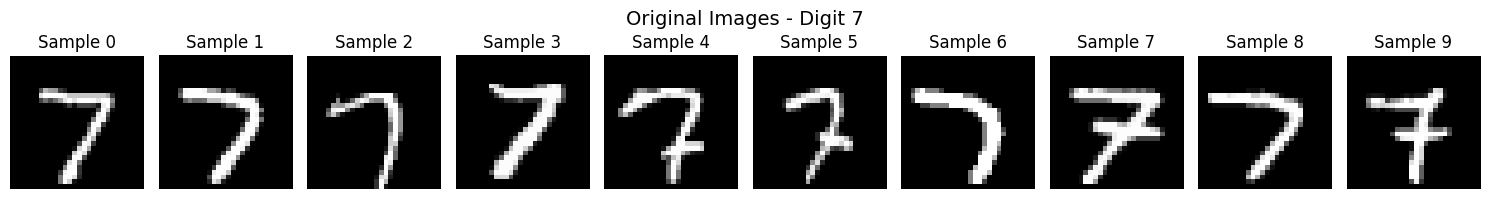

2. Showing feature maps for each convolutional layer...
Getting 10 samples of digit 7...

Visualizing Conv1 (1→8 channels) - 28×28
Feature map shape: torch.Size([10, 8, 28, 28])


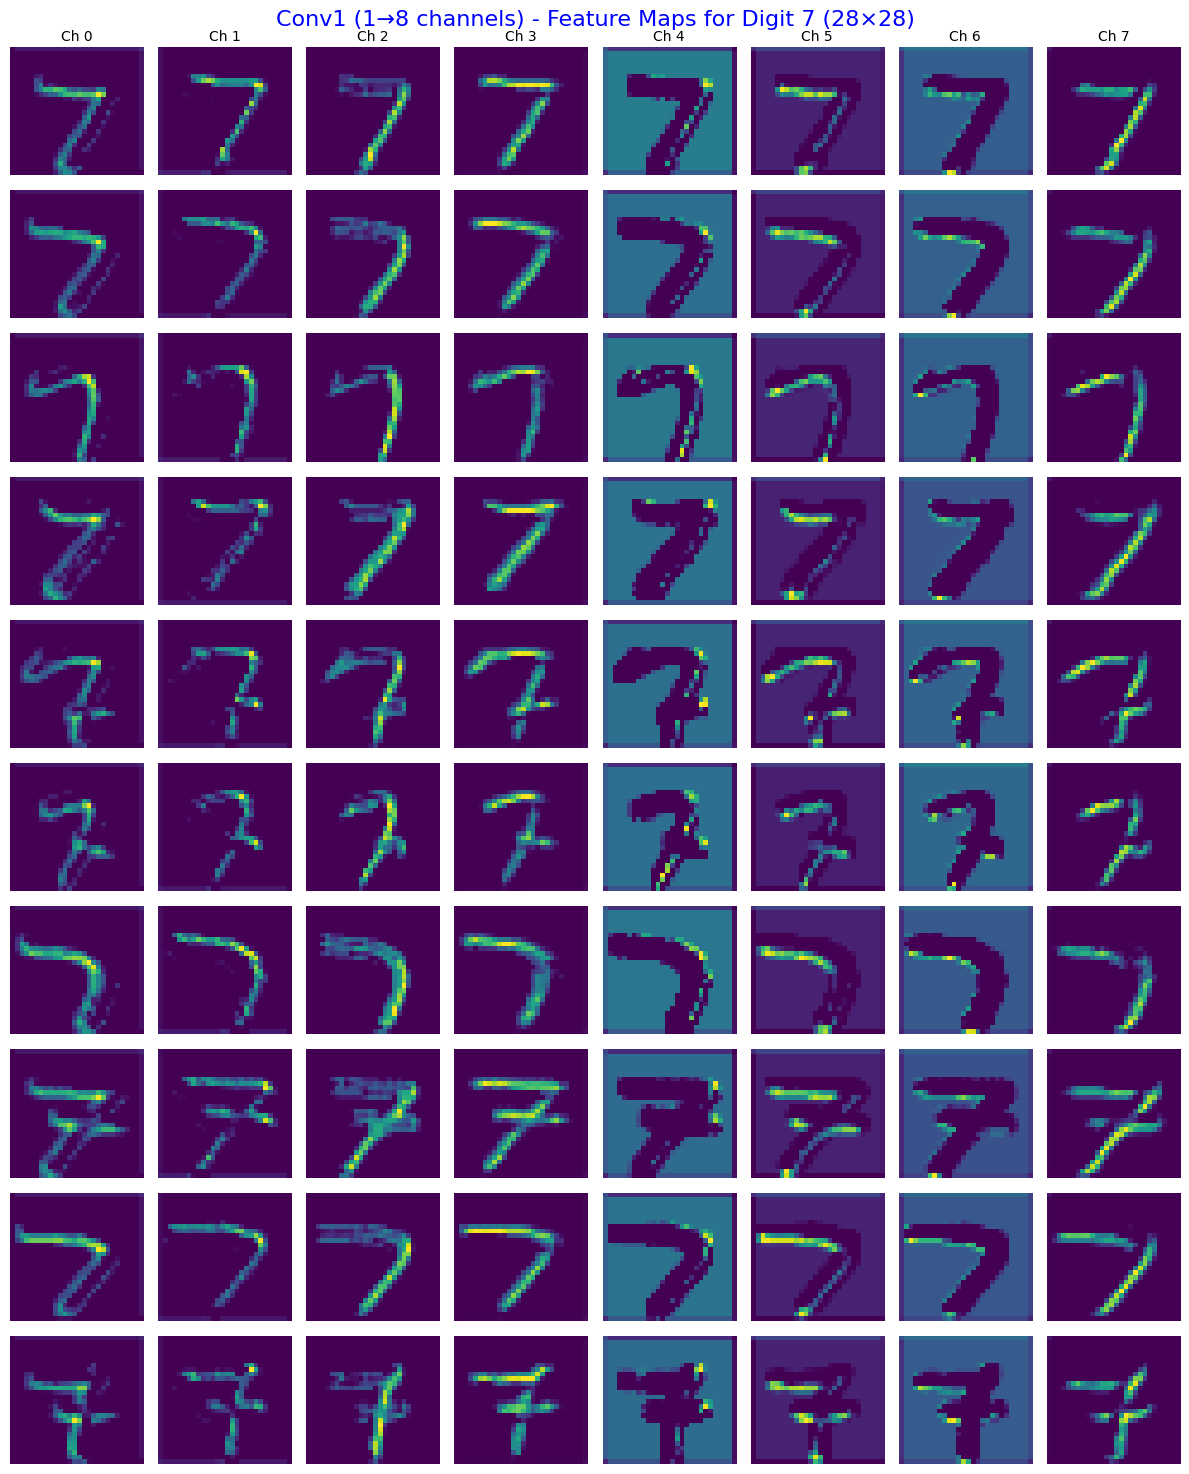


Visualizing Conv2 (8→16 channels) - 28×28
Feature map shape: torch.Size([10, 16, 28, 28])


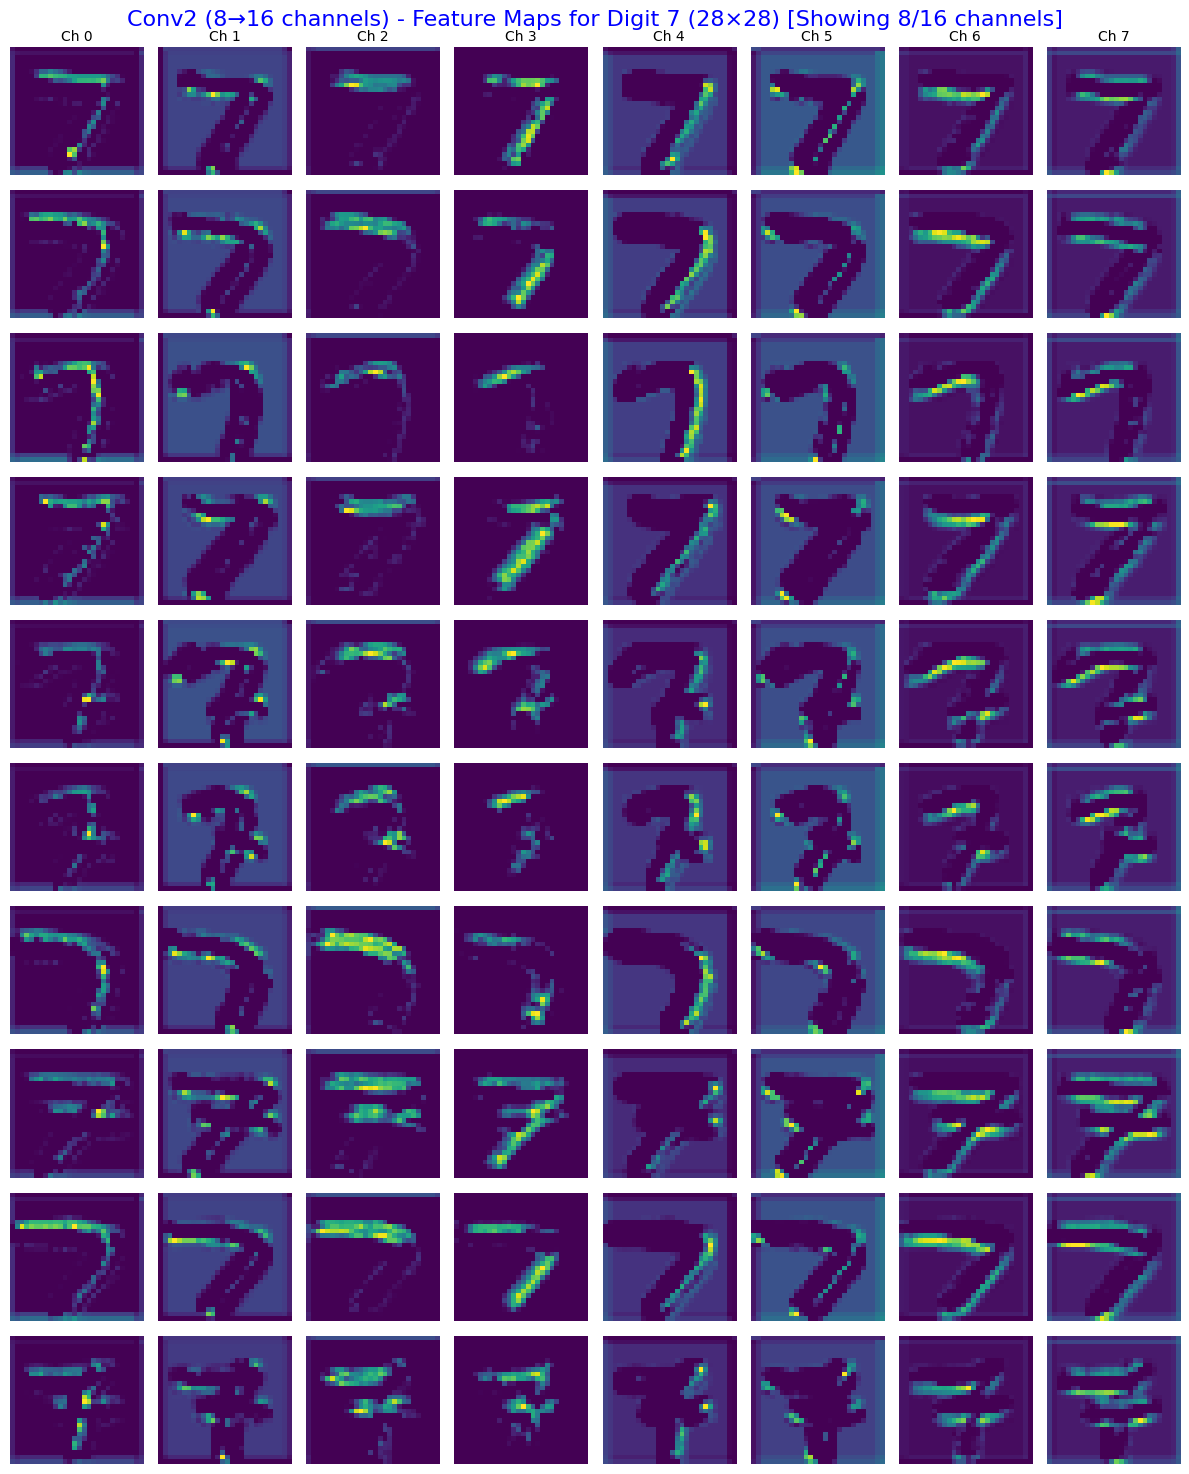


Visualizing MaxPool1 (after Conv2) - 14×14
Feature map shape: torch.Size([10, 16, 14, 14])


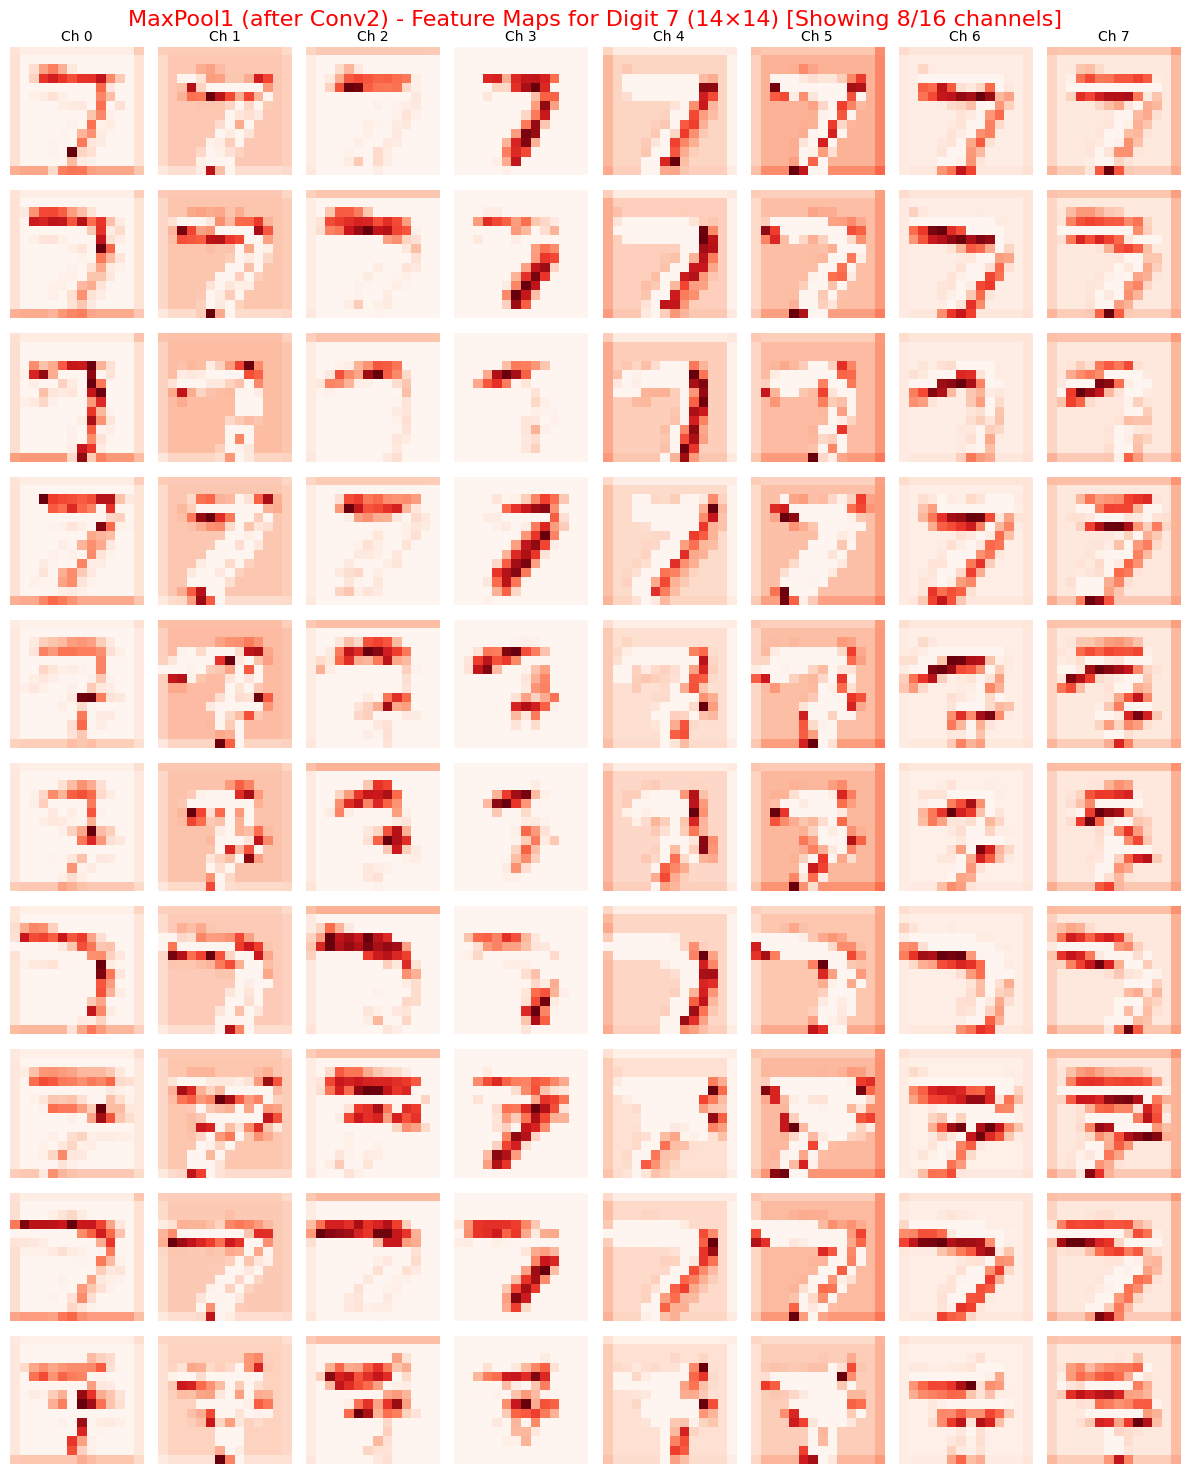


Visualizing Conv3 (16→32 channels) - 14×14
Feature map shape: torch.Size([10, 32, 14, 14])


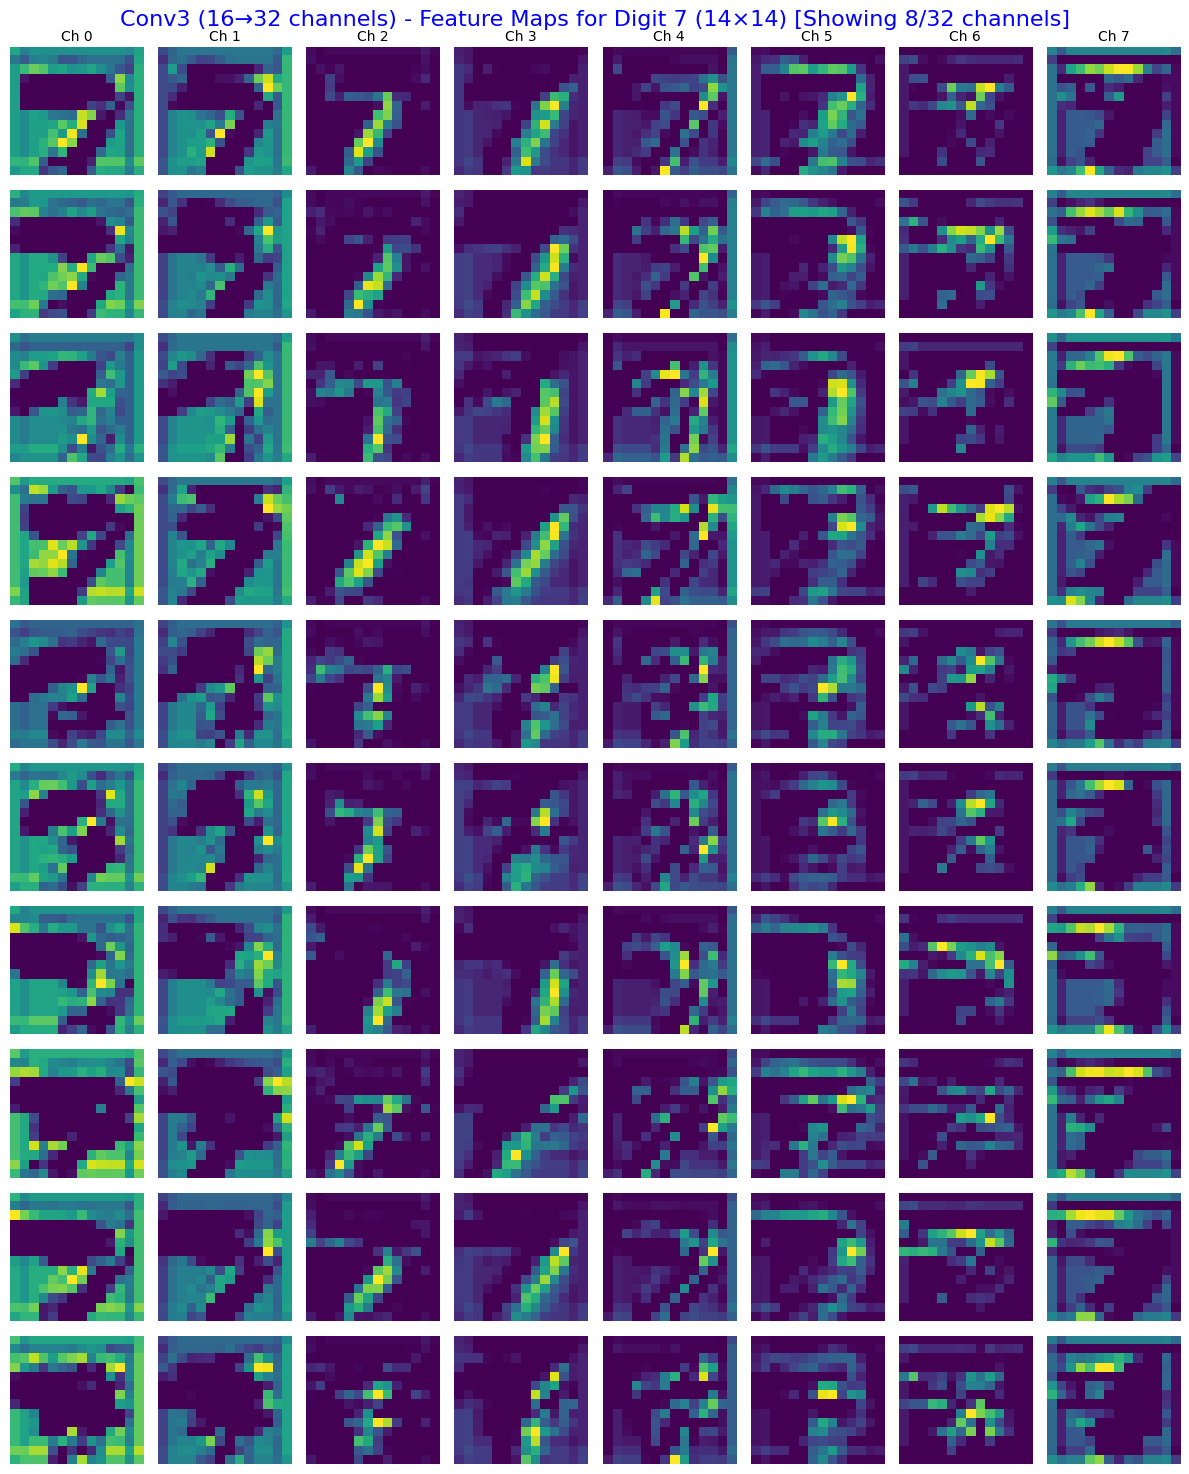


Visualizing 1x1 Conv (32→1 channels) - 14×14
Feature map shape: torch.Size([10, 1, 14, 14])


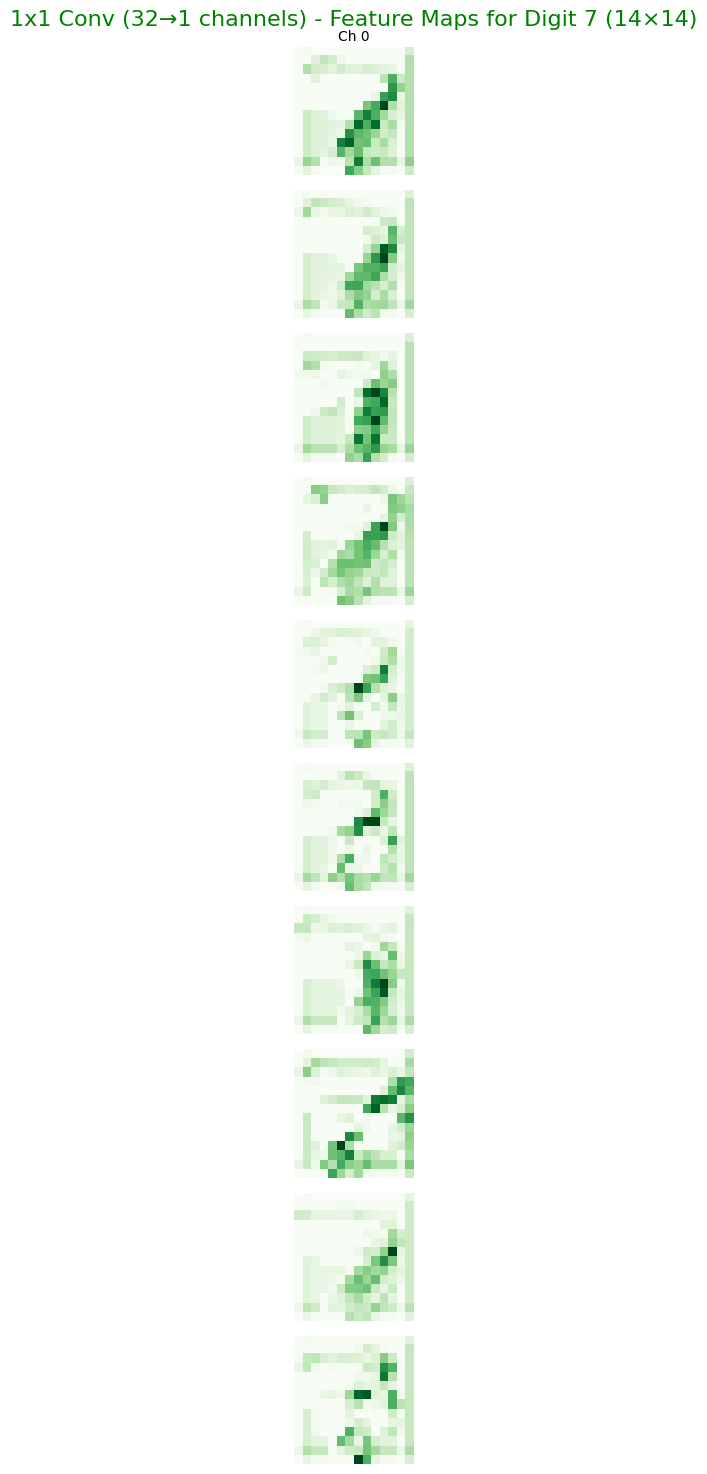

3. Analyzing feature statistics...

Feature Map Statistics for Digit 7:
------------------------------------------------------------
CONV1 (BN+ReLU):
  Shape: torch.Size([10, 8, 28, 28]) (expected: [10, 8, 28, 28])
  Mean activation:   0.3153
  Std activation:    0.5941
  Min activation:    0.0000
  Max activation:    6.1359
  Sparsity:           57.89%

CONV2 (BN+ReLU):
  Shape: torch.Size([10, 16, 28, 28]) (expected: [10, 16, 28, 28])
  Mean activation:   0.2930
  Std activation:    0.4687
  Min activation:    0.0000
  Max activation:    5.3045
  Sparsity:           41.95%

MAXPOOL1 (2x2):
  Shape: torch.Size([10, 16, 14, 14]) (expected: [10, 16, 14, 14])
  Mean activation:   0.4391
  Std activation:    0.6112
  Min activation:    0.0000
  Max activation:    5.3045
  Sparsity:           29.78%
  Size reduction:     75.00% (from Conv2)

CONV3 (BN+ReLU):
  Shape: torch.Size([10, 32, 14, 14]) (expected: [10, 32, 14, 14])
  Mean activation:   0.4969
  Std activation:    0.7603
  Min acti

In [43]:
run_visualization_example(model, test_loader, digit=7)